# 학습 목표
- 항원성 예측을 위한 데이터 수집 및 전처리 방법을 학습한다.

In [ ]:
# 필요한 라이브러리 임포트
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
import matplotlib.pyplot as plt
import requests
import tarfile
import gzip
import shutil
import io

In [ ]:
# 데이터 다운로드 및 추출 함수
def download_and_extract_data():
    print("데이터 다운로드 중...")
    url = "https://services.healthtech.dtu.dk/suppl/immunology/NAR_NetMHCpan_NetMHCIIpan/NetMHCpan_train.tar.gz"
    response = requests.get(url)

    print("압축 파일 추출 중...")
    with gzip.open(io.BytesIO(response.content), 'rb') as f_in:
        with open('NetMHCpan_train.tar', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    with tarfile.open('NetMHCpan_train.tar', 'r') as tar:
        tar.extractall()

    print("데이터 추출 완료!")
    os.remove('NetMHCpan_train.tar')  # 임시 파일 삭제

download_and_extract_data()

데이터 다운로드 중...
압축 파일 추출 중...
데이터 추출 완료!


In [ ]:
# 데이터 로드 및 전처리 함수
def load_data(data_dir='NetMHCpan_train'):
    print("데이터 로드 중...")
    ba_files = [f for f in os.listdir(data_dir) if f.startswith('c00') and f.endswith('_ba')]
    el_files = [f for f in os.listdir(data_dir) if f.startswith('c00') and f.endswith('_el')]

    all_data = []

    # BA 데이터 로드 (Binding Affinity)
    for file in ba_files:
        with open(os.path.join(data_dir, file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 3:
                    peptide = parts[0]
                    label = float(parts[1])
                    mhc = parts[2]
                    all_data.append({
                        'peptide': peptide,
                        'label': label,
                        'mhc': mhc,
                        'data_type': 'ba'
                    })

    # EL 데이터 로드 (Eluted Ligand)
    for file in el_files:
        with open(os.path.join(data_dir, file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 3:
                    peptide = parts[0]
                    label = float(parts[1])
                    mhc = parts[2]
                    all_data.append({
                        'peptide': peptide,
                        'label': label,
                        'mhc': mhc,
                        'data_type': 'el'
                    })

    # 데이터프레임 생성
    df = pd.DataFrame(all_data)

    # MHC 정보 로드 (allelelist 파일)
    mhc_info = {}
    try:
        with open(os.path.join(data_dir, 'allelelist'), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    cell_line = parts[0]
                    alleles = parts[1:]
                    mhc_info[cell_line] = alleles
    except FileNotFoundError:
        print("allelelist 파일을 찾을 수 없습니다. MHC 정보 매핑을 건너뜁니다.")

    # 셀라인 ID를 MHC로 매핑 (가능한 경우)
    if mhc_info:
        def map_to_mhc(row):
            if row['mhc'] in mhc_info:
                return mhc_info[row['mhc']][0]  # 첫 번째 MHC 사용
            return row['mhc']

        df['mhc_mapped'] = df.apply(map_to_mhc, axis=1)
    else:
        df['mhc_mapped'] = df['mhc']

    print(f"총 {len(df)} 개의 샘플이 로드되었습니다.")
    print(f"Binding Affinity 데이터: {len(df[df['data_type'] == 'ba'])}")
    print(f"Eluted Ligand 데이터: {len(df[df['data_type'] == 'el'])}")

    return df

df = load_data()
df

데이터 로드 중...
총 13076386 개의 샘플이 로드되었습니다.
Binding Affinity 데이터: 208093
Eluted Ligand 데이터: 12868293


,peptide,label,mhc,data_type,mhc_mapped
0,AAAAAAYAAM,0.177415,H-2-Db,ba,H-2-Db
1,AAAAAAYAAM,0.463100,H-2-Kb,ba,H-2-Kb
2,AAAAFEAAL,0.362118,BoLA-3:00101,ba,BoLA-3:00101
3,AAAAFEAAL,0.468035,BoLA-3:00201,ba,BoLA-3:00201
4,AAAAFEAAL,0.522653,HLA-B48:01,ba,HLA-B48:01
...,...,...,...,...,...
13076381,YWTIVKPGDILVIN,0.000000,pat-ST,el,"HLA-A03:01,HLA-A24:02,HLA-B07:02,HLA-B27:05"
13076382,YYCNHSMSDK,0.000000,pat-ST,el,"HLA-A03:01,HLA-A24:02,HLA-B07:02,HLA-B27:05"
13076383,YYPFLPLFTSSL,0.000000,pat-ST,el,"HLA-A03:01,HLA-A24:02,HLA-B07:02,HLA-B27:05"
13076384,YYVVTGQDKD,0.000000,pat-ST,el,"HLA-A03:01,HLA-A24:02,HLA-B07:02,HLA-B27:05"


In [ ]:
df_sample = df.sample(1000)
df_sample

,peptide,label,mhc,data_type,mhc_mapped
4033966,KVVASVKRFSTFSA,0.0,HLA-B35:01,el,HLA-B35:01
2382628,GIGAGQIL,0.0,RPMI8226,el,"HLA-A30:01,HLA-A68:02,HLA-B15:03,HLA-B15:10,HL..."
3107299,VHIRSTKGPIDV,0.0,A15-A15,el,"BoLA-1:00901,BoLA-4:02401,BoLA-2:02501"
7176647,FRDELVMKAL,0.0,Line.55,el,"HLA-A68:01,HLA-A02:01,HLA-B13:02,HLA-B35:03,HL..."
5400498,TLSPVNHSL,1.0,T98G,el,"HLA-A02:01,HLA-B39:06,HLA-C07:02"
...,...,...,...,...,...
4923130,MRRDNASQVYP,0.0,RA957,el,"HLA-A02:20,HLA-A68:01,HLA-B35:03,HLA-B39:01,HL..."
1159470,AVPVPLPDMVLPPS,0.0,HLA-A02:07,el,HLA-A02:07
4176012,NVFGRVYLAHEGI,0.0,HLA-B57:01,el,HLA-B57:01
7751615,WLIFPAWPL,0.0,pat-AC2,el,"HLA-A03:01,HLA-A32:01,HLA-B27:05,HLA-B45:01"


In [ ]:
df_sample['label'] = df_sample.apply(lambda row: 1 if (row['data_type'] == 'ba' and row['label'] < 500) or
                                      (row['data_type'] == 'el' and row['label'] > 0.5) else 0, axis=1)
df_sample

,peptide,label,mhc,data_type,mhc_mapped
4033966,KVVASVKRFSTFSA,0,HLA-B35:01,el,HLA-B35:01
2382628,GIGAGQIL,0,RPMI8226,el,"HLA-A30:01,HLA-A68:02,HLA-B15:03,HLA-B15:10,HL..."
3107299,VHIRSTKGPIDV,0,A15-A15,el,"BoLA-1:00901,BoLA-4:02401,BoLA-2:02501"
7176647,FRDELVMKAL,0,Line.55,el,"HLA-A68:01,HLA-A02:01,HLA-B13:02,HLA-B35:03,HL..."
5400498,TLSPVNHSL,1,T98G,el,"HLA-A02:01,HLA-B39:06,HLA-C07:02"
...,...,...,...,...,...
4923130,MRRDNASQVYP,0,RA957,el,"HLA-A02:20,HLA-A68:01,HLA-B35:03,HLA-B39:01,HL..."
1159470,AVPVPLPDMVLPPS,0,HLA-A02:07,el,HLA-A02:07
4176012,NVFGRVYLAHEGI,0,HLA-B57:01,el,HLA-B57:01
7751615,WLIFPAWPL,0,pat-AC2,el,"HLA-A03:01,HLA-A32:01,HLA-B27:05,HLA-B45:01"


In [ ]:
# 라벨 분포 확인
print("바인더(1):", len(df_sample[df_sample['label'] == 1]))
print("비바인더(0):", len(df_sample[df_sample['label'] == 0]))
print("비율:", len(df_sample[df_sample['label'] == 1]) / len(df_sample))

바인더(1): 79
비바인더(0): 921
비율: 0.079


In [ ]:
# 데이터를 학습, 검증, 테스트 세트로 분할
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42, stratify=df_sample['label'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['label'])

print(f"학습 데이터: {len(train_df)}, 검증 데이터: {len(val_df)}, 테스트 데이터: {len(test_df)}")

학습 데이터: 680, 검증 데이터: 120, 테스트 데이터: 200


In [ ]:
# ProtBERT 모델과 토크나이저를 로드합니다
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
bert_model = BertModel.from_pretrained("Rostlab/prot_bert")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

In [ ]:
# 펩타이드 데이터셋 클래스
class PeptideDataset(Dataset):
    def __init__(self, peptides, labels, tokenizer, max_length=32):
        self.peptides = peptides
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.peptides)

    def __getitem__(self, idx):
        peptide = self.peptides[idx]
        label = self.labels[idx]

        # 공백 추가하여 아미노산 시퀀스 토큰화
        peptide = " ".join(peptide)

        encoding = self.tokenizer(peptide,
                                 return_tensors='pt',
                                 max_length=self.max_length,
                                 padding='max_length',
                                 truncation=True)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# ProtBERT 기반 모델 클래스
class ProtBertClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size=1024, num_classes=1):
        super(ProtBertClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS 토큰 출력
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
# 학습, 검증, 테스트 데이터셋 생성
train_dataset = PeptideDataset(
    peptides=train_df['peptide'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer
)

val_dataset = PeptideDataset(
    peptides=val_df['peptide'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer
)

test_dataset = PeptideDataset(
    peptides=test_df['peptide'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer
)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# 학습 함수
def train_model(train_loader, val_loader, model, device, num_epochs=3):
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = nn.BCEWithLogitsLoss()

    best_val_auc = 0
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        epoch_loss = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as progress_bar:
            for batch in progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), labels)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증 모드
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), labels)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs).squeeze().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # ROC-AUC 계산
        val_auc = roc_auc_score(all_labels, all_preds)
        val_aucs.append(val_auc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}")

        # 최적 모델 저장
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), 'best_peptide_model.pt')

    # 학습 진행 시각화
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_aucs, label='Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

    return train_losses, val_losses, val_aucs

# 모델 평가 함수
def evaluate_model(test_loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(outputs).squeeze().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # numpy 배열로 변환
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # ROC-AUC 계산
    auc = roc_auc_score(all_labels, all_preds)

    # PR-AUC 계산
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    pr_auc = average_precision_score(all_labels, all_preds)

    # 결과 출력
    print(f"Test ROC-AUC: {auc:.4f}")
    print(f"Test PR-AUC: {pr_auc:.4f}")

    # ROC 및 PR 곡선 그리기
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.savefig('evaluation_curves.png')
    plt.show()

    return auc, pr_auc, all_preds, all_labels

사용 디바이스: cuda


Epoch 1/3: 100%|██████████| 43/43 [00:19<00:00,  2.22it/s, loss=0.6610]


Epoch 1/3 - Train Loss: 0.3183, Val Loss: 0.2574, Val AUC: 0.6867


Epoch 2/3: 100%|██████████| 43/43 [00:19<00:00,  2.22it/s, loss=0.1433]


Epoch 2/3 - Train Loss: 0.2747, Val Loss: 0.2472, Val AUC: 0.6997


Epoch 3/3: 100%|██████████| 43/43 [00:19<00:00,  2.20it/s, loss=0.3934]


Epoch 3/3 - Train Loss: 0.2836, Val Loss: 0.2536, Val AUC: 0.7628


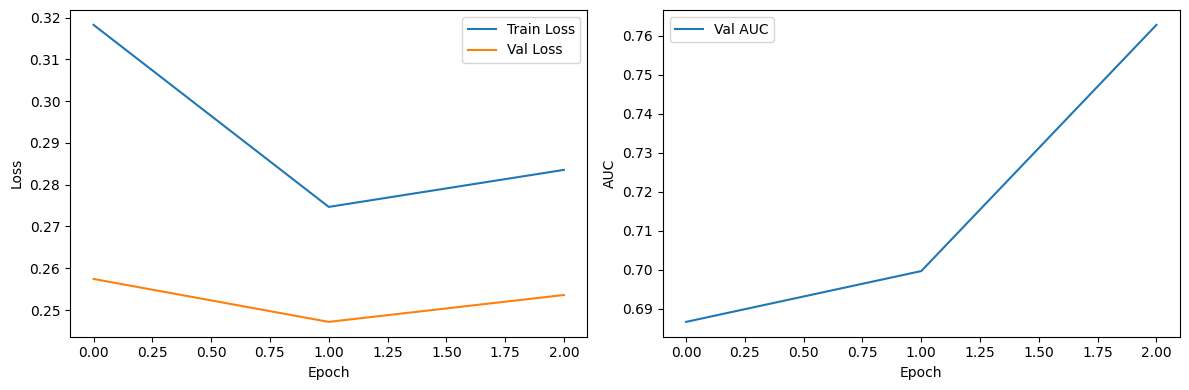

In [ ]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")

model = ProtBertClassifier(bert_model).to(device)
train_losses, val_losses, val_aucs = train_model(train_loader, val_loader, model, device, num_epochs=3)

In [ ]:
# 학습 중 저장된 최적의 모델 로드
model.load_state_dict(torch.load('best_peptide_model.pt'))

<All keys matched successfully>

Evaluating: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


Test ROC-AUC: 0.8315
Test PR-AUC: 0.2164


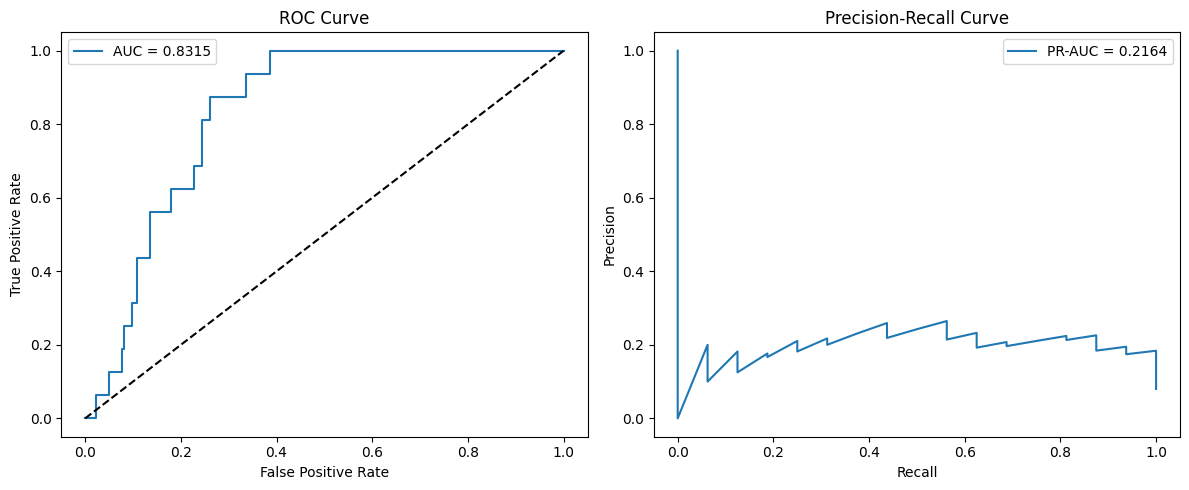


===== 최종 평가 결과 =====
ROC-AUC: 0.8315
PR-AUC: 0.2164


In [ ]:
# 테스트 세트에서 모델 평가
auc, pr_auc, preds, labels = evaluate_model(test_loader, model, device)

# 최종 결과 출력
print("\n===== 최종 평가 결과 =====")
print(f"ROC-AUC: {auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")